# P A N D A S
---
Read all datalist and naming them

In [76]:
import pandas as pd

real_df = pd.read_csv('../data/train_set.csv')
generated_df = pd.read_csv('../data/gen_data.csv')
test_df = pd.read_csv('../data/test_set.csv')

## F U N C T I O N S
---
* For unique values

In [2]:
def get_unique(df):
    import numpy as np
    categories = { }
    length = len(df)
    threshold = length // 20
    for col in df.columns:
        unique = np.sort(df[col].unique())
        if df[col].dtype == np.int or len(unique) < threshold:
            categories[col] = unique
    return categories

# categories = get_unique(read_df)

In [5]:
def round_list(categories, df):
    from bisect import bisect_left
    def round_val(mlist, mnum):
        pos = bisect_left(mlist, mnum)
        if pos == 0:
            return mlist[0]
        if pos == len(mlist):
            return mlist[-1]
        before = mlist[pos - 1]
        after = mlist[pos]
        if after - mnum < mnum - before:
            return after
        else:
            return before

    for col in categories:
        rounder = categories[col]
        for i in range(len(df)):
            df[col][i] = round_val(rounder, df[col][i])
    return df

# rounded_generated_df = round_list(categories, generated_df)

In [6]:
categories = get_unique(real_df)
rounded_generated_df = round_list(categories, generated_df)

## P Y T O R C H
---
* Generating Data Unlimited with Generator

In [7]:
import torch
from torch.autograd import Variable

def generate(G, gen_num=1000):
    z = torch.rand(gen_num, 100)
    c_ = torch.zeros(gen_num // 2, 1)
    for i in range(1, 2):
        temp = torch.zeros(gen_num // 2, 1) + i
        c_ = torch.cat([c_, temp], 0)
    c = torch.zeros(gen_num, 2)
    c.scatter_(1, c_.type(torch.LongTensor), 1)
    z, c = Variable(z), Variable(c)
    G.eval()
    results = G(z, c)
    resultsd = torch.cat([results.data, c_], 1)
    G.train()
    return pd.DataFrame(
        resultsd.numpy(),
        columns=real_df.columns
    )

In [39]:
from models.generators import ConditionalBNGenerator as CBNG

G = CBNG(100, 70, 2)
# G_weight = torch.load('../data/generator_weight')
# G.load_state_dict(G_weight)

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
xgbc = XGBClassifier()
def xgbrun(X_train, y_train, X_test, y_test):
    xgbc.fit(X_train,y_train)
    Y_pred_xgb=xgbc.predict(X_test)
    xgb_auc = roc_auc_score(y_test,Y_pred_xgb)
    return xgb_auc

def auc_hist(real_set, fake_set, test_set):
    auclist = []
    for i in range(len(fake_data) // 100):
        real_set_t, real_set_l = real_set.drop('Grant.Status', axis=1), real_set['Grant.Status']
        fake_set_t, fake_set_l = fake_set[: i * 100].drop('Grant.Status', axis=1), fake_set[: i * 100]['Grant.Status']
        test_set_t, test_set_l = test_set.drop('Grant.Status', axis=1), test_set['Grant.Status']
        train_set_t, train_set_l = pd.concat([real_set_t, fake_set_t]), pd.concat([real_set_l, fake_set_l])
        auc = xgbrun(train_set_t, train_set_l, test_set_t, test_set_l)
        auclist += [auc]
    return auclist

In [40]:
fake_data = generate(G, 2000)
fake_data = fake_data * real_df.std() + real_df.mean()
fake_data = round_list(categories, fake_data)

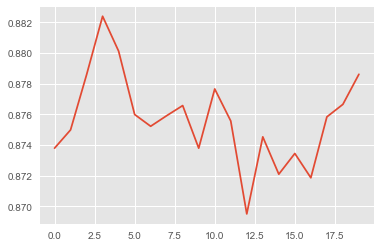

In [42]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

real_set = real_df
fake_set = fake_data
test_set = test_df
auclist = auc_hist(real_set, fake_set, test_set)
plt.plot(auclist)
plt.show()

In [63]:
# additional_set = test_set[:1000]
# atest_set = test_set[1000:]

# auclist_ac = auc_hist(real_set, additional_set, atest_set)
# auclist_ge = auc_hist(real_set, fake_data[:1000], atest_set)

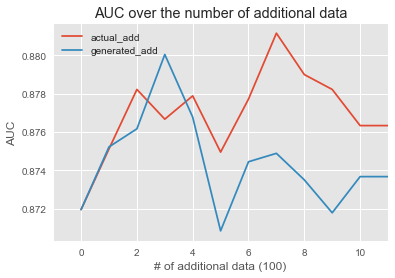

In [63]:
plt.cla()
plt.clf()
plt.xlim(-1, 11)

actual_add, = plt.plot(auclist_ac, label='actual_add')
generated_add, = plt.plot(auclist_ge, label='generated_add')
plt.title('AUC over the number of additional data')
plt.xlabel('# of additional data (100)')
plt.ylabel('AUC')
plt.legend(handles=[actual_add, generated_add])
plt.show()

In [68]:
# X_train
# y_train
# X_test
# y_test

In [84]:
from sklearn.model_selection import train_test_split
train_df2, test_df2 = train_test_split(pd.read_csv('../data/train_preprocessed2.csv'), train_size = 0.75, random_state=21)
# X_train = train_df.drop('Grant.Status', axis=1)
# y_train = train_df[['Grant.Status']]
# X_test = test_df.drop('Grant.Status', axis=1)
# y_test = test_df[['Grant.Status']]
# train_df2.to_csv('../data/train_set2.csv', index=False)
# test_df2.to_csv('../data/test_set2.csv', index=False)

/Users/garb50/anaconda3/envs/fluid/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [93]:
# additional_set = test_df2[:1000]
# atest_set = test_df2[1000:]
fake_data2 = pd.read_csv('../result/gen_data.csv')

# auclist_ac2 = auc_hist(train_df2, test_df2[:1000], test_df2[1000:])
auclist_ge2 = auc_hist(train_df2, fake_data2, test_df2[1000:])

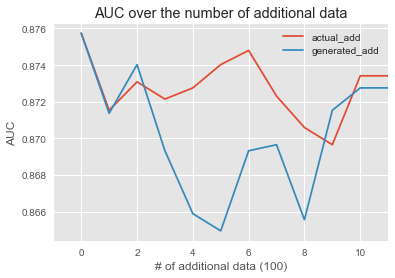

In [94]:
plt.cla()
plt.clf()
plt.xlim(-1, 11)

actual_add, = plt.plot(auclist_ac2, label='actual_add')
generated_add, = plt.plot(auclist_ge2, label='generated_add')
plt.title('AUC over the number of additional data')
plt.xlabel('# of additional data (100)')
plt.ylabel('AUC')
plt.legend(handles=[actual_add, generated_add])
plt.show()

In [ ]:
plt.hist(dfgg, align='left', rwidth=0.5, bins=range(0, 16))
plt.xlabel("# of people in team")
plt.show()

In [ ]:
dfg = df.groupby('Number.people')['Number.people'].count()
dfg.index = dfg.index.astype(int)
dfg

In [ ]:
dfgg = df['Number.people']
dfgg.index += 1

In [ ]:
(df3[['Person.ID.{}'.format(attr) for attr in range(1, 16)]].notna().sum(axis=1) == 0).sum()

In [ ]:
dfrfcd = (df3[['RFCD.Code.{}'.format(attr) for attr in range(1, 6)]].fillna(0) != 0).sum(axis=1)
plt.hist(dfrfcd, align='left', rwidth=0.5, bins=range(0, 7))
plt.xlabel("# of RECD in team")
plt.show()

In [ ]:
dfseo = (df3[['SEO.Code.{}'.format(attr) for attr in range(1, 6)]].fillna(0) != 0).sum(axis=1)
plt.hist(dfseo, align='left', rwidth=0.5, bins=range(0, 7))
plt.xlabel("# of SEO in team")
plt.show()

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
data_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                                         transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.1307,), (0.3081,)),
                                                         transforms.Lambda(lambda x: x.view(-1) )
                                                       ])),
                                        batch_size=128, shuffle=True)

In [ ]:
for data, label in data_loader:
    print(data.size())
    break

In [ ]:
tdf = pd.DataFrame([1, 2, 3], columns=data_loader.dataset.df.columns)

In [ ]:
tdf

In [ ]:
def show_result():
    images = read_csv('../data/gen_data.csv', index=False)

In [ ]:
images = pd.read_csv('../data/gen_data.csv')

In [ ]:
images = images.drop(['784'], axis=1)

In [ ]:
data = images.loc[0].as_matrix()

In [ ]:
tdata = torch.Tensor(data)

In [ ]:
tdata = tdata.contiguous().view(-1, 28)

In [ ]:
ax[0, 0].cla()
ax[0, 0].imshow(tdata.numpy(), cmap='gray')

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(5, 5))

In [ ]:
import itertools
for i, j in itertools.product(range(10), range(10)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)


In [ ]:
plt.show()

In [ ]:
plt.imshow(tdata.numpy(), cmap='gray')
# tdata

In [ ]:
def show_images_with_label(images, labels, view_num=10):
    fig, ax = plt.subplots(view_num, view_num, figsize=(10, 10))
    for i in range(view_num * view_num):
        ax[i // 10, i % 10].imshow(images.loc[i + 300].as_matrix().reshape((28, -1)), cmap='gray')

In [ ]:
show_images_with_label(images, None)

In [ ]:
df2 = pd.read_csv('../data/gen_data.csv')
df1 = pd.read_csv('../data/train_preprocessed2.csv')

In [ ]:
round_list(get_unique(df1), df2)

In [ ]:
df2.to_csv('../data/rounded.csv', index=False)

In [ ]:
df2

In [ ]:
df1['A..papers'].max()
df1['A..papers'].mean()
df1['A..papers'].std()

In [ ]:
X_train, y_train, X_test, y_test = spliter(df1)

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

xgbrun(X_train, y_train, X_test, y_test)

In [ ]:
# X_train
# df2.drop('Grant.Status', axis=1)

X_train = pd.concat([X_train, df2.drop(['Grant.Status'], axis=1)])
len(X_train)

In [ ]:
# y_train.rename('Grant.Status')
y_train = pd.concat([y_train, df2['Grant.Status'].to_frame('Grant.Status')])
len(y_train)

In [ ]:
xgbrun(X_train, y_train, X_test, y_test)

In [ ]:
train_set, test_set = train_test_split(df1, train_size=0.75)

In [ ]:
train_set.to_csv('../data/train_set.csv', index=False)
test_set.to_csv('../data/test_set.csv', index=False)

In [ ]:
train_ = pd.concat([train_set.drop(['Grant.Status'], axis=1), df2.drop(['Grant.Status'], axis=1)])
label_ = pd.concat([train_set['Grant.Status'], df2['Grant.Status']]).to_frame('Grant.Status')

In [ ]:
xgbrun(train_, label_, test_set.drop(['Grant.Status'], axis=1), test_set['Grant.Status'].to_frame('Grant.Status'))

In [ ]:
xgbrun(train_set.drop(['Grant.Status'], axis=1), train_set['Grant.Status'].to_frame('Grant.Status'), test_set.drop(['Grant.Status'], axis=1), test_set['Grant.Status'].to_frame('Grant.Status'))

In [ ]:
df4 = pd.read_csv('../result/gen_data.csv')
df5 = pd.read_csv('../result2/gen_data.csv')

In [ ]:
train__ = pd.concat([train_, df5.drop(['Grant.Status'], axis=1)])

In [ ]:
label__ = pd.concat([label_, df5['Grant.Status'].to_frame('Grant.Status')])

In [ ]:
len(train__), len(label__)

In [ ]:
xgbrun(train__, label__, test_set.drop(['Grant.Status'], axis=1), test_set['Grant.Status'].to_frame('Grant.Status'))

In [ ]:
train_2 = pd.concat([train_set.drop(['Grant.Status'], axis=1), df2.drop(['Grant.Status'], axis=1)])
label_2 = pd.concat([train_set['Grant.Status'], df2['Grant.Status']]).to_frame('Grant.Status')

In [ ]:
xgbrun(train_2, label_2, test_set.drop(['Grant.Status'], axis=1), test_set['Grant.Status'].to_frame('Grant.Status'))

In [ ]:
from models.generators import ConditionalBNGenerator
model = ConditionalBNGenerator(100, 70, 2)
state_dict = torch.load('../data/generator_weight')
model.load_state_dict(state_dict)

In [ ]:
generated = generate(model)

In [ ]:
generated = generated * df1.std() + df1.mean()
round_list(categories, generated)

In [ ]:
train_10 = pd.concat([train_set.drop(['Grant.Status'], axis=1), generated.drop(['Grant.Status'], axis=1)])
label_10 = pd.concat([train_set['Grant.Status'], generated['Grant.Status']]).to_frame('Grant.Status')

In [ ]:
xgbrun(train_10, label_10, test_set.drop(['Grant.Status'], axis=1), test_set['Grant.Status'].to_frame('Grant.Status'))

In [ ]:
train_9 = train_10[:900]
label_9 = label_10[:900]
len(train_9)

In [ ]:
xgbrun(train_9, label_9, test_set.drop(['Grant.Status'], axis=1), test_set['Grant.Status'].to_frame('Grant.Status'))

In [ ]:
auclist = []
for i in range(11):
    trainer = pd.concat([train_set.drop(['Grant.Status'], axis=1), generated[:i*100].drop(['Grant.Status'], axis=1)])
    labeler = pd.concat([train_set['Grant.Status'], generated[:i*100]['Grant.Status']]).to_frame('Grant.Status')
    auc = xgbrun(trainer, labeler, test_set.drop(['Grant.Status'], axis=1), test_set['Grant.Status'].to_frame('Grant.Status'))
    print(auc)
    auclist += [auc]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(auclist)
plt.show()